In [259]:
import os
import pandas as pd
import numpy as np
from PIL import Image

data_root = "./dataset"

In [260]:
csv_file = os.path.join(data_root, "image_data.csv")
df = pd.read_csv(csv_file)

print("\nDATASET OVERVIEW")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(df.head(10))


DATASET OVERVIEW
Shape: (3762, 2)
Columns: ['low_res', 'high_res']

First 10 rows:
    low_res high_res
0   1_2.jpg    1.jpg
1   2_2.jpg    2.jpg
2   3_2.jpg    3.jpg
3   4_2.jpg    4.jpg
4   5_2.jpg    5.jpg
5   6_2.jpg    6.jpg
6   7_2.jpg    7.jpg
7   8_2.jpg    8.jpg
8   9_2.jpg    9.jpg
9  10_2.jpg   10.jpg


In [261]:
high_res_dir = os.path.join(data_root, "high res")
low_res_dir = os.path.join(data_root, "low res")

high_res_images = os.listdir(high_res_dir)
low_res_images = os.listdir(low_res_dir)

print(f"\nHigh Resolution Images: {len(high_res_images)}")
print(f"Low Resolution Images: {len(low_res_images)}")


High Resolution Images: 1254
Low Resolution Images: 3762


In [262]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torchvision.models import MobileNet_V2_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [291]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim(img1, img2):
    c1, c2 = 0.01 ** 2, 0.03 ** 2
    mean1 = img1.mean()
    mean2 = img2.mean()
    var1 = np.var(img1)
    var2 = np.var(img2)
    cov = np.mean((img1 - mean1) * (img2 - mean2))
    return ((2 * mean1 * mean2 + c1) * (2 * cov + c2)) / \
           ((mean1 ** 2 + mean2 ** 2 + c1) * (var1 + var2 + c2))

# FEATURE 2: TESTING VARIOUS LOSS FUNCTIONS
class PerceptualLoss(nn.Module):
    """VGG16-based perceptual loss for better visual quality"""
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights='DEFAULT').features
        self.feature_extractor = nn.Sequential(*list(vgg)[:16]).eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.mse = nn.MSELoss()
    
    def forward(self, output, target):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(output.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(output.device)
        
        output_norm = (output - mean) / std
        target_norm = (target - mean) / std
        
        output_features = self.feature_extractor(output_norm)
        target_features = self.feature_extractor(target_norm)
        
        return self.mse(output_features, target_features)    

In [277]:
class ImageDataset(Dataset):
    def __init__(self, high_res_dir, mapping_df, downscale_factor=4, target_size=(256, 256), max_samples=None, augment=False):
        self.high_res_dir = high_res_dir
        self.mapping = mapping_df[:max_samples] if max_samples else mapping_df
        self.downscale_factor = downscale_factor
        self.target_size = target_size
        self.augment = augment
        
    def __len__(self):
        return len(self.mapping)
    
    def apply_augmentation(self, img_array):
        """FEATURE 1: DATA AUGMENTATION - Apply random transformations to improve generalization"""
        if np.random.rand() > 0.5:
            img_array = np.fliplr(img_array)
        
        if np.random.rand() > 0.5:
            img_array = np.flipud(img_array)
        
        k = np.random.randint(0, 4)
        if k > 0:
            img_array = np.rot90(img_array, k=k)
        
        if np.random.rand() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            img_array = np.clip(img_array * factor, 0, 1)
        
        if np.random.rand() > 0.5:
            mean = img_array.mean()
            factor = np.random.uniform(0.8, 1.2)
            img_array = np.clip((img_array - mean) * factor + mean, 0, 1)
        
        # Ensure positive strides/contiguous memory after augmentations
        return np.ascontiguousarray(img_array)
    
    def __getitem__(self, idx):
        high_res_name = self.mapping.iloc[idx, 1]
        high_res_path = os.path.join(self.high_res_dir, high_res_name)
        
        high_img = Image.open(high_res_path).convert('RGB')
        high_img = high_img.resize(self.target_size, Image.Resampling.LANCZOS)
        
        low_width = max(1, high_img.width // self.downscale_factor)
        low_height = max(1, high_img.height // self.downscale_factor)
        low_img = high_img.resize((low_width, low_height), Image.Resampling.BICUBIC)
        low_img = low_img.resize(self.target_size, Image.Resampling.BICUBIC)
        
        low_img = np.array(low_img, dtype=np.float32) / 255.0
        high_img = np.array(high_img, dtype=np.float32) / 255.0
        
        # FEATURE 1: DATA AUGMENTATION - Apply augmentation if enabled
        if self.augment:
            seed = np.random.randint(0, 2**31 - 1)
            np.random.seed(seed)
            low_img = self.apply_augmentation(low_img)
            np.random.seed(seed)
            high_img = self.apply_augmentation(high_img)
        
        # Ensure arrays are contiguous (no negative strides) before torch conversion
        low_img = np.ascontiguousarray(low_img)
        high_img = np.ascontiguousarray(high_img)
        
        low_tensor = torch.from_numpy(low_img.transpose(2, 0, 1))
        high_tensor = torch.from_numpy(high_img.transpose(2, 0, 1))
        
        return low_tensor, high_tensor

In [278]:
# Data augmentation enabled for training, disabled for validation/test
# FEATURE 1: DATA AUGMENTATION - Enable augmentation for training
dataset = ImageDataset(high_res_dir, df, downscale_factor=4, target_size=(256, 256), max_samples=200, augment=True)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)
# FEATURE 1: DATA AUGMENTATION - Disable augmentation for validation/test
# Disable augmentation for validation and test sets
dataset_val_test = ImageDataset(high_res_dir, df, downscale_factor=4, target_size=(256, 256), max_samples=200, augment=False)
train_dataset_aug, val_dataset_no_aug, test_dataset_no_aug = random_split(
    dataset_val_test, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset_no_aug, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset_no_aug, batch_size=4, shuffle=False, num_workers=0)

print(f"Train: {train_size} | Val: {val_size} | Test: {test_size}")

Train: 140 | Val: 30 | Test: 30


In [286]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class MobileNetV2Pretrained(nn.Module):
    """Pre-trained MobileNetV2 adapted for super-resolution via transfer learning"""
    def __init__(self):
        super(MobileNetV2Pretrained, self).__init__()
        mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = mobilenet.features
        
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.decoder = nn.Sequential(
            nn.Conv2d(1280, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )
    
    def forward(self, x):
        features = self.features(x)
        features = nn.functional.interpolate(features, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        out = self.decoder(features)
        skip = nn.functional.interpolate(x, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return torch.clamp(out + 0.5 * skip, 0.0, 1.0)

# FEATURE 3: ARCHITECTURE TUNING - ResNet18 with U-Net decoder
class ResNet18SuperResolution(nn.Module):
    """ResNet18 with U-Net decoder for super-resolution"""
    def __init__(self):
        super(ResNet18SuperResolution, self).__init__()
        resnet = models.resnet18(weights='DEFAULT')
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        for param in list(self.conv1.parameters()) + list(self.bn1.parameters()) + \
                    list(self.layer1.parameters()) + list(self.layer2.parameters()):
            param.requires_grad = False
        
        self.up1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(512, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(256, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.up4 = nn.Sequential(
            nn.Conv2d(128, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.final = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1)
        )
    
    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        x_pool = self.maxpool(x1)
        x2 = self.layer1(x_pool)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        
        d1 = self.up1(x5)
        d1 = torch.cat([d1, x4], dim=1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, x3], dim=1)
        d3 = self.up3(d2)
        d3 = torch.cat([d3, x2], dim=1)
        d4 = self.up4(d3)
        out = self.final(d4)
        
        # Ensure output matches input spatial size (e.g., 256x256)
        out = nn.functional.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        
        return torch.clamp(out, 0.0, 1.0)

In [273]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    batch_losses = []
    
    pbar = tqdm(loader, desc="Training batch", leave=False)
    for low, high in pbar:
        low, high = low.to(device), high.to(device)
        optimizer.zero_grad()
        output = model(low)
        loss = criterion(output, high)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        batch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
    return total_loss / len(loader), np.mean(batch_losses)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Validation", leave=False)
    with torch.no_grad():
        for low, high in pbar:
            low, high = low.to(device), high.to(device)
            output = model(low)
            loss = criterion(output, high)
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

def train_model(model, train_loader, val_loader, criterion, epochs=10, lr=1e-3):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'batch_avg_loss': [],
        'learning_rate': []
    }
    
    pbar = tqdm(range(epochs), desc="Epoch")
    for epoch in pbar:
        train_loss, batch_avg = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['batch_avg_loss'].append(batch_avg)
        history['learning_rate'].append(lr)
        
        pbar.set_postfix({'train_loss': f'{train_loss:.4f}', 'val_loss': f'{val_loss:.4f}'})
    
    return history

In [274]:
# FEATURE 2: TESTING VARIOUS LOSS FUNCTIONS - Compare 3 different loss functions
loss_functions = {
    'L1Loss': nn.L1Loss(),
    'L2Loss': nn.MSELoss(),
    'PerceptualLoss': PerceptualLoss()
}

print("Loss functions defined: L1Loss, L2Loss (MSE), and Perceptual Loss (VGG16-based)")

Loss functions defined: L1Loss, L2Loss (MSE), and Perceptual Loss (VGG16-based)


In [279]:
# FEATURE 2: TESTING VARIOUS LOSS FUNCTIONS - Train SimpleCNN with different loss functions
print("\n=== Training SimpleCNN with different loss functions ===")
models_by_loss = {}

for loss_name, criterion in loss_functions.items():
    print(f"\nTraining SimpleCNN with {loss_name}...")
    model = SimpleCNN().to(device)
    history = train_model(model, train_loader, val_loader, criterion, epochs=10, lr=1e-3)
    models_by_loss[loss_name] = {'model': model, 'history': history}

# Keep best SimpleCNN for comparison
model_scratch = models_by_loss['L1Loss']['model']
history_scratch = models_by_loss['L1Loss']['history']

print("SimpleCNN training with all loss functions completed")


=== Training SimpleCNN with different loss functions ===

Training SimpleCNN with L1Loss...


Epoch: 100%|██████████| 10/10 [02:25<00:00, 14.52s/it, train_loss=0.0398, val_loss=0.0375]



Training SimpleCNN with L2Loss...


Epoch: 100%|██████████| 10/10 [02:25<00:00, 14.58s/it, train_loss=0.0033, val_loss=0.0032]



Training SimpleCNN with PerceptualLoss...


Epoch: 100%|██████████| 10/10 [11:48<00:00, 70.81s/it, train_loss=5.6354, val_loss=5.5007]

SimpleCNN training with all loss functions completed


In [281]:
# FEATURE 3: ARCHITECTURE TUNING - Train MobileNetV2 (Pre-trained Transfer Learning)
print("\n=== Training MobileNetV2 (Transfer Learning) ===")
model_mobilenet = MobileNetV2Pretrained().to(device)
history_mobilenet = train_model(model_mobilenet, train_loader, val_loader, nn.L1Loss(), epochs=10, lr=5e-4)

print("MobileNetV2 training completed")


=== Training MobileNetV2 (Transfer Learning) ===


Epoch: 100%|██████████| 10/10 [18:37<00:00, 111.71s/it, train_loss=0.1088, val_loss=0.0857]

MobileNetV2 training completed


In [287]:
# FEATURE 3: ARCHITECTURE TUNING - Train ResNet18 (Pre-trained with U-Net Decoder)
print("\n=== Training ResNet18 (U-Net decoder) ===")
model_resnet = ResNet18SuperResolution().to(device)
history_resnet = train_model(model_resnet, train_loader, val_loader, nn.L1Loss(), epochs=10, lr=5e-4)

print("ResNet18 training completed")


=== Training ResNet18 (U-Net decoder) ===


Epoch: 100%|██████████| 10/10 [03:24<00:00, 20.49s/it, train_loss=0.1197, val_loss=0.0824]

ResNet18 training completed


In [292]:
def evaluate(model, loader, device):
    model.eval()
    psnr_scores = []
    ssim_scores = []
    
    with torch.no_grad():
        for low, high in loader:
            low, high = low.to(device), high.to(device)
            output = model(low)
            
            output = output.cpu().numpy()
            high = high.cpu().numpy()
            
            for i in range(output.shape[0]):
                out_img = np.clip(output[i].transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
                high_img = np.clip(high[i].transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
                
                psnr_scores.append(psnr(out_img, high_img))
                ssim_scores.append(ssim(out_img.astype(float), high_img.astype(float)))
    
    return np.mean(psnr_scores), np.mean(ssim_scores)

print("\n=== Test Results ===")
psnr_scratch, ssim_scratch = evaluate(model_scratch, test_loader, device)
psnr_mobilenet, ssim_mobilenet = evaluate(model_mobilenet, test_loader, device)
psnr_resnet, ssim_resnet = evaluate(model_resnet, test_loader, device)

# Evaluate all loss function variants
results_by_loss = {}
for loss_name, data in models_by_loss.items():
    psnr_val, ssim_val = evaluate(data['model'], test_loader, device)
    results_by_loss[loss_name] = {'psnr': psnr_val, 'ssim': ssim_val}

print(f"\nSimpleCNN (L1Loss)")
print(f"  PSNR: {psnr_scratch:.2f} dB")
print(f"  SSIM: {ssim_scratch:.4f}")

print(f"\nMobileNetV2 (Pre-trained)")
print(f"  PSNR: {psnr_mobilenet:.2f} dB")
print(f"  SSIM: {ssim_mobilenet:.4f}")

print(f"\nResNet18 (U-Net)")
print(f"  PSNR: {psnr_resnet:.2f} dB")
print(f"  SSIM: {ssim_resnet:.4f}")

# FEATURE 2: TESTING VARIOUS LOSS FUNCTIONS - Display results for each loss function
print(f"\n--- Loss Function Comparison ---")
for loss_name, metrics in results_by_loss.items():
    print(f"{loss_name}: PSNR={metrics['psnr']:.2f} dB, SSIM={metrics['ssim']:.4f}")


=== Test Results ===

SimpleCNN (L1Loss)
  PSNR: 32.04 dB
  SSIM: 0.9424

MobileNetV2 (Pre-trained)
  PSNR: 28.58 dB
  SSIM: 0.7717

ResNet18 (U-Net)
  PSNR: 28.69 dB
  SSIM: 0.8271

--- Loss Function Comparison ---
L1Loss: PSNR=32.04 dB, SSIM=0.9424
L2Loss: PSNR=33.14 dB, SSIM=0.9615
PerceptualLoss: PSNR=27.96 dB, SSIM=0.8370


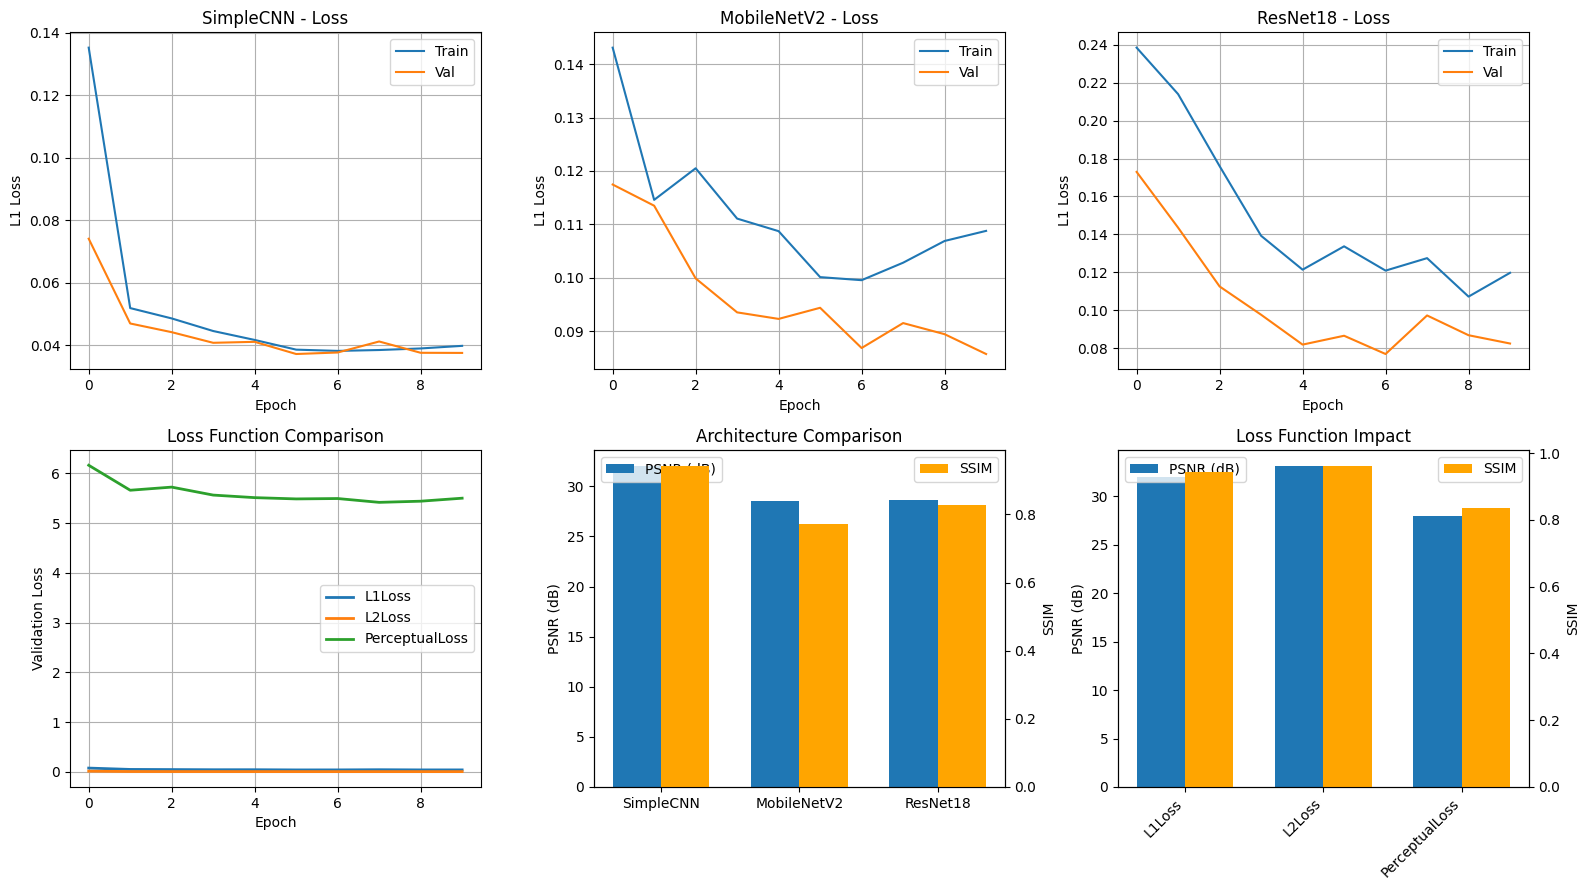

In [293]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

# SimpleCNN Loss curves
axes[0, 0].plot(history_scratch['train_loss'], label='Train')
axes[0, 0].plot(history_scratch['val_loss'], label='Val')
axes[0, 0].set_title('SimpleCNN - Loss')
axes[0, 0].set_ylabel('L1 Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid()

# MobileNetV2 Loss curves
axes[0, 1].plot(history_mobilenet['train_loss'], label='Train')
axes[0, 1].plot(history_mobilenet['val_loss'], label='Val')
axes[0, 1].set_title('MobileNetV2 - Loss')
axes[0, 1].set_ylabel('L1 Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid()

# ResNet18 Loss curves
axes[0, 2].plot(history_resnet['train_loss'], label='Train')
axes[0, 2].plot(history_resnet['val_loss'], label='Val')
axes[0, 2].set_title('ResNet18 - Loss')
axes[0, 2].set_ylabel('L1 Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].legend()
axes[0, 2].grid()

# Loss function comparison
axes[1, 0].clear()
for loss_name, data in models_by_loss.items():
    axes[1, 0].plot(data['history']['val_loss'], label=loss_name, linewidth=2)
axes[1, 0].set_title('Loss Function Comparison')
axes[1, 0].set_ylabel('Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid()

# FEATURE 3: ARCHITECTURE TUNING - Compare SimpleCNN, MobileNetV2, and ResNet18
models_names = ['SimpleCNN', 'MobileNetV2', 'ResNet18']
psnr_vals = [psnr_scratch, psnr_mobilenet, psnr_resnet]
ssim_vals = [ssim_scratch, ssim_mobilenet, ssim_resnet]

x = np.arange(len(models_names))
width = 0.35

axes[1, 1].bar(x - width/2, psnr_vals, width, label='PSNR (dB)')
ax2 = axes[1, 1].twinx()
ax2.bar(x + width/2, ssim_vals, width, label='SSIM', color='orange')
axes[1, 1].set_ylabel('PSNR (dB)')
ax2.set_ylabel('SSIM')
axes[1, 1].set_title('Architecture Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models_names)
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

# FEATURE 2: TESTING VARIOUS LOSS FUNCTIONS - Visualize impact of different loss functions
loss_names = list(results_by_loss.keys())
loss_psnr = [results_by_loss[n]['psnr'] for n in loss_names]
loss_ssim = [results_by_loss[n]['ssim'] for n in loss_names]

x_loss = np.arange(len(loss_names))
axes[1, 2].bar(x_loss - width/2, loss_psnr, width, label='PSNR (dB)')
ax3 = axes[1, 2].twinx()
ax3.bar(x_loss + width/2, loss_ssim, width, label='SSIM', color='orange')
axes[1, 2].set_ylabel('PSNR (dB)')
ax3.set_ylabel('SSIM')
axes[1, 2].set_title('Loss Function Impact')
axes[1, 2].set_xticks(x_loss)
axes[1, 2].set_xticklabels(loss_names, rotation=45, ha='right')
axes[1, 2].legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

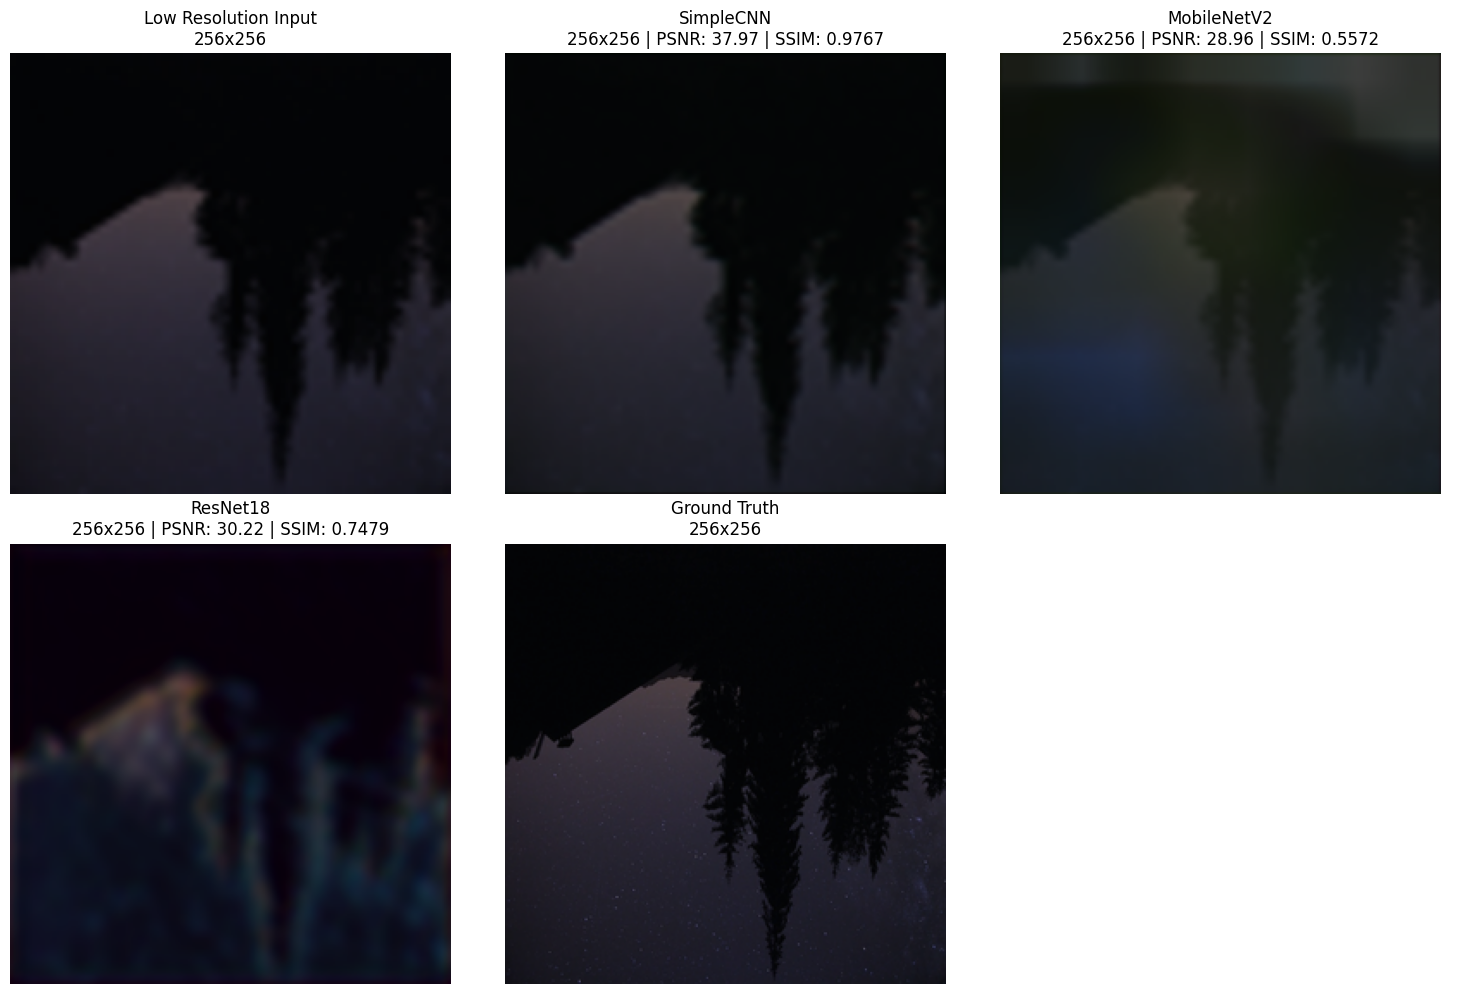

In [297]:
idx_demo = np.random.randint(0, len(test_dataset))
low_demo, high_demo = test_dataset[idx_demo]

# FEATURE 1: DATA AUGMENTATION (no augmentation on test set)
# FEATURE 2: TESTING VARIOUS LOSS FUNCTIONS (L1Loss used here)
# FEATURE 3: ARCHITECTURE TUNING (Compare 3 different models)
low_demo = low_demo.unsqueeze(0).to(device)
high_demo = high_demo.to(device)

model_scratch.eval()
model_mobilenet.eval()
model_resnet.eval()

# Compute model outputs without gradients
with torch.no_grad():
    out_scratch = model_scratch(low_demo)
    out_mobilenet = model_mobilenet(low_demo)
    out_resnet = model_resnet(low_demo)

low_img = np.clip(low_demo[0].cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
high_img = np.clip(high_demo.cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
out_scratch_img = np.clip(out_scratch[0].detach().cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
out_mobilenet_img = np.clip(out_mobilenet[0].detach().cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
out_resnet_img = np.clip(out_resnet[0].detach().cpu().numpy().transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)

psnr_scratch_demo = psnr(out_scratch_img, high_img)
psnr_mobilenet_demo = psnr(out_mobilenet_img, high_img)
psnr_resnet_demo = psnr(out_resnet_img, high_img)
ssim_scratch_demo = ssim(out_scratch_img.astype(float), high_img.astype(float))
ssim_mobilenet_demo = ssim(out_mobilenet_img.astype(float), high_img.astype(float))
ssim_resnet_demo = ssim(out_resnet_img.astype(float), high_img.astype(float))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(low_img)
axes[0, 0].set_title(f'Low Resolution Input\n{low_img.shape[1]}x{low_img.shape[0]}')
axes[0, 0].axis('off')

axes[0, 1].imshow(out_scratch_img)
axes[0, 1].set_title(f'SimpleCNN\n{out_scratch_img.shape[1]}x{out_scratch_img.shape[0]} | PSNR: {psnr_scratch_demo:.2f} | SSIM: {ssim_scratch_demo:.4f}')
axes[0, 1].axis('off')

axes[0, 2].imshow(out_mobilenet_img)
axes[0, 2].set_title(f'MobileNetV2\n{out_mobilenet_img.shape[1]}x{out_mobilenet_img.shape[0]} | PSNR: {psnr_mobilenet_demo:.2f} | SSIM: {ssim_mobilenet_demo:.4f}')
axes[0, 2].axis('off')

axes[1, 0].imshow(out_resnet_img)
axes[1, 0].set_title(f'ResNet18\n{out_resnet_img.shape[1]}x{out_resnet_img.shape[0]} | PSNR: {psnr_resnet_demo:.2f} | SSIM: {ssim_resnet_demo:.4f}')
axes[1, 0].axis('off')

axes[1, 1].imshow(high_img)
axes[1, 1].set_title(f'Ground Truth\n{high_img.shape[1]}x{high_img.shape[0]}')
axes[1, 1].axis('off')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()